# Advanced classification models

In the previous lecture you learned the basics of the classificatoin problem, and in particular we discussed metrics and linear methods. In this *notebook*, we will review more advanced algorithms describing the probability of belonging to a given class as a function of the input features.
In particular, we will mention:

 * Decision Trees
 * Boosted Decision Trees
 * Neural Networks
 * Parametric models
 
## No Free Lunch Theorem
A model is a simplified version of the set of observations it was trained with. 
Simplifications are to be initended as an attempt of discarding unnecessary details which is unlikely to generalize to new observations. However, deciding what to discard and what to retain in the model construction requires assumptions and hypotheses on the underlying model. For example, a linear regressioin model is based on the assumption that the relation between dependent and independend variables is well approximated by a linear function, while the deviatoin of the observed variables from the predicted value, is random noise that can be safely ignored.

In a 1996 article, David Wolpert demonstrated that without any assumption on the nature of the data, then there is no reason to prefer a model to another. This consideration is known as the **No Free Lunch Theorem** e represents a foundation of Machine Learning.

For some data sets, the *best-working* model can be a linear model, for other might be a neural network, but *a priori* there is no guarantee that one performs better than the other.

Of course, giben a data sample of data one may test them all and choose the best one, but in practice thi is not feaaasible and it is therefore important to have a perception of what are the fundamental assumptions that make it reasonable to expect that a model will work properly. This may drive the practicioner's choice towards a linear regression or a decision tree for a smple task with limited amount of data, or towards a Boosted Decision Tree or a Neural Network for a more advanced use case.

Our attempt in this notebook is to provide you with a perception of what is an "assumption" on the dataset and how important is balancing between model complexity and injected hypotheses, given basic properties of the dataset and task.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

## The data sample

In order to compare different classification models and play with the meaning of the *No Free Lunch Theorem*, we will need a rather complicated dataset, but to visualize the model effectively the problem cannot be defined in too many dimensions, we will restrict ourseleves to a 2D problem which is particularly easy to represent on a computer display.

We will use a dataset with two caategories, only. Let's call them 0 (*blue*) and 1 (*red*).
The observations are distributed as adjacent rolls. 

For the human eye, the problem is not difficult, we can easily separate the red and blue domains with high accuracy, but for an algorithm without prior knowledge on the smaple, the task is far from trivial.



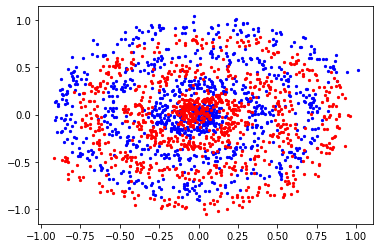

In [2]:
f = 20
n0 = n1 = 1000

def generate_dataset (f=20, n0=1000, n1=1000):
    t0 = np.random.uniform(0, 1, n0)
    x0 = np.random.normal (t0 * np.sin(f*t0), 0.05)
    y0 = np.random.normal (t0 * np.cos(f*t0), 0.05)

    t1 = np.random.uniform(0, 1, n1)
    x1 = np.random.normal (t1 * np.sin(f*t1 + np.pi), 0.05)
    y1 = np.random.normal (t1 * np.cos(f*t1 + np.pi), 0.05)

    return x0, y0, x1, y1

x0, y0, x1, y1 = generate_dataset()

plt.scatter(x0, y0, s=5, color='blue')
plt.scatter(x1, y1, s=5, color='red')

## Linear and polynomial models

Clearly, a linear model is not adequate to the task. 
But it may be useful to define a first term for comparison, defining a metric and assigning a number to the concept of "*working poorly*".

In [3]:
def make_plot(model=None, title=None):
    plt.scatter(x0, y0, s=5, color='blue', alpha=0.6)
    plt.scatter(x1, y1, s=5, color='red', alpha=0.6)
    plt.xlabel("x")
    plt.ylabel("y")
    if title is not None:
        plt.title(title)

    if model is not None:
        xAxis = np.linspace(-1,1,200)
        yAxis = np.linspace(-1,1,200)
        XY = np.array([(x_, y_) for x_ in xAxis for y_ in yAxis])
        chat = model.predict_proba(XY)[:,1].reshape((len(xAxis), len(yAxis)))
        #plt.contour(xAxis, yAxis, chat.T, cmap='seismic')
        plt.imshow(chat.T, extent = (-1,1,-1,1), cmap='seismic', alpha=0.4, origin='lower')
        plt.clim(-0.1,  1.1)


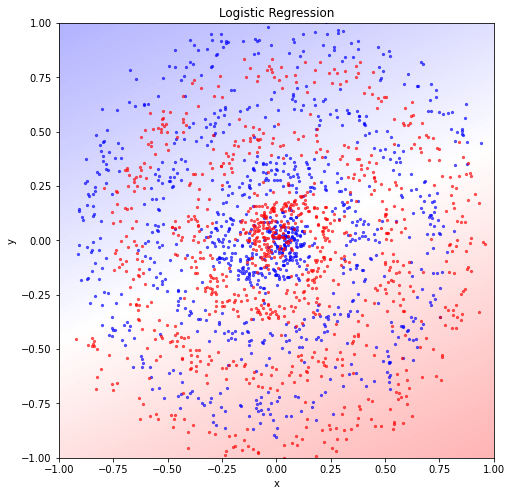

In [4]:
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

poly = PolynomialFeatures(1)
method = LogisticRegression(penalty='none')
logistic_regression = Pipeline([('poly', poly), ('method', method)])

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(n0), np.ones(n1)))
logistic_regression.fit(X, c)
plt.figure(figsize=(8,8))
make_plot(logistic_regression, "Logistic Regression")

Even preprocessingt the input features, with a polynomial regression technique we do not expect great results...  

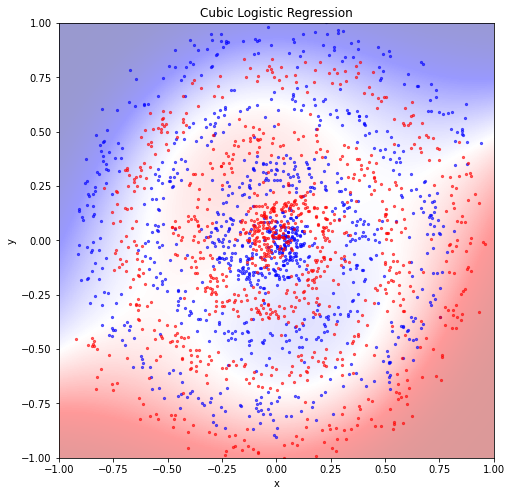

In [5]:
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

poly = PolynomialFeatures(3)
method = LogisticRegression(penalty='none')
polynomial_logistic = Pipeline([('poly', poly), ('method', method)])

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(n0), np.ones(n1)))
polynomial_logistic.fit(X, c)
plt.figure(figsize=(8,8))
make_plot(polynomial_logistic, "Cubic Logistic Regression")

## ROC curve
As discussed in the previous talk, we need to define a metric to compare the performance of the two algorithms. 
In High Energy Physics (I am biased towards, sorry), typically we choose to represent the performance of a binary classification algorithm as a *ROC curve* or *Receiver Operating Characteristic* (ROC) curve.
These plots are built by representing ont he *x* axis the signal selection efficiency (*True Positive Rate*) and on the *y* axis the background rejection (*True Negative Rate*).


Unfortunately, the convetion used in HEP is slightly different from that used in other fields. For example, in `scikit-learn`, instead of represeting the *background rejection* the *background selection efficiency* is used. The information provided by the two definition is exactly the same, it's just a graphical representation choice.

In the next code block, we will build a ROC curve using the `metrics` module of `scikit-learn` and, for simplicity, we will define a function `plot_roc` that builds the ROC curve for us.


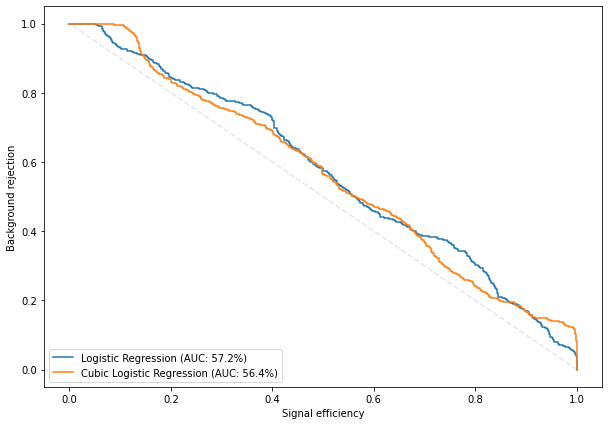

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score 

def plot_roc(X, c, model, title, fmt=''):
    chat_lr = model.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(c, chat_lr)
    plt.plot(tpr, 1-fpr, fmt, label=f"{title} (AUC: {100*roc_auc_score(c,chat_lr):.1f}%)")


plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, logistic_regression, "Logistic Regression")
plot_roc(X, c, polynomial_logistic, "Cubic Logistic Regression")

plt.legend(loc='lower left')

plt.show()

### Interpretation of the ROC curve and the Area Under the Curve (ROC-AUC)

In order to interpret the plots of the ROC curve, we need to consider that an algorithm selecting completely randomly the signal and background entries will be represented by a straight line connecting the point (0,1) and the point (1,0).
In other words, we caan choose to randomly select a fraction $f$ of the data sample, which statistically will correspond to selecting a fraction $f$ of the signal and rejecting a fraction $1 - f$ of the background. 
As the threshold $f$ can be selected arbitrarily, the *working point* of the selection algorithm can be chosen to coorespond to each point of this rectilinear ROC curve.

Any algorithm will present two extreme working points, correponding to selecting the entiere sample (signal efficiency 100%, background rejection 0%) or rejecting the whole sample (signal efficiency 0%, background rejection 100%). These two *working points* are always part of the ROC curve of any algorithm.

That said, the ideal algorithm is able to select 100% of the signal while rejecting 100% of the background, providing a working point corresponding to (1,1) in the ROC curve plane.

A selection algorithm performing better than the random selection criterion, but worse than the ideal one, will be represented by a ROC curve between these two extreme cases.

Now, the logistic regression we implemented above, even in its polynomnial expansion, is represented by ROC curves very close to the random selection, suggesting that the discrimination power of these algorithms on the roll sample is not outstanding.

In order to quantify in a single metric the performance of a binary classification algorithm, we often use the *Area Under the Curve* (AUC), *i.e* the integral of the ROC curve. A value of the AUC at 50% inidicates that the algorithm is performing a random selection of signal and background, while the AUC of 100% indicates and algorithm providing an ideal separation of the two classes.

Please note that, depending on the problem, the existence of an algorithm able to perfectly separate the signal and background categories is not guaranteed. If the *generative pdf* of the two samples are superposed, even the best theoretical algorithm tranied on infinite statistics **can not** achieve full separation between signal and background. 

Comparing the AUC of the logistic regression with the algorithm relying on the polynomial preprocessing of the feaatures, we see that adding higher order polynomials enable better performance, but we remaing extremely far from the ideal separation between the two classes, that still, our eye seems able to achieve.

## Decision Trees

One of the simplest algorithms widely adopted to solve the binary classification problem is the *Decision Tree* (DT). 
A DT is aa sequence of selection criteria organized in a tree structure that subsequently partitionate the parameter space, trying to identify regions where either of the two categories are purer to associate each region with one or the other class.

DTs are grown from the *root* to the *leaves*, optimizing, at each subsequent step, the *binary cross-entropy*, or a slightly faster approximaation known as Gini index.
The number of selection criteria applied in the sequence is named *depth* of the tree.

Let's try to visualize the growth of a decision tree by training six decition trees with increasing *depth*, while comparing how the parameter space is partitioned.

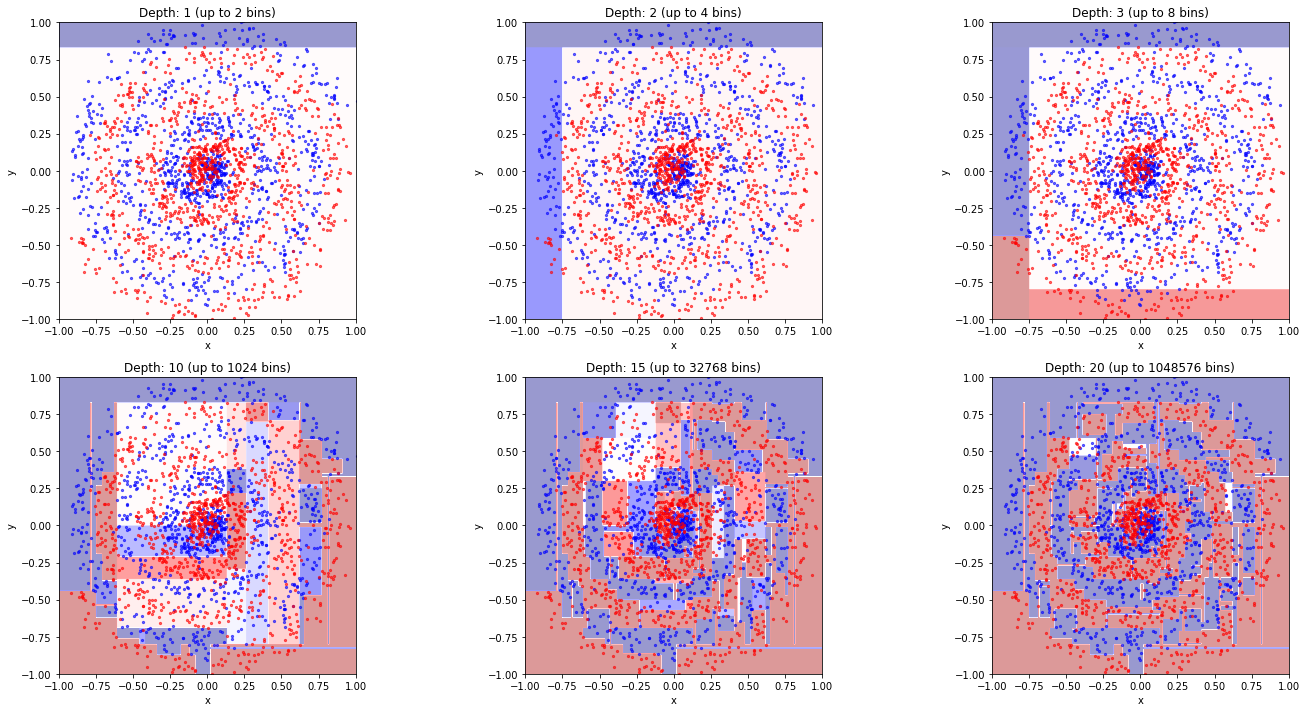

In [7]:
from sklearn.tree import DecisionTreeClassifier as Dt
plt.figure(figsize=(20,10))
for iPlot, depth in enumerate([1, 2, 3, 10, 15, 20], 1):
    plt.subplot(2,3, iPlot)

    ## Instanciate
    dt = Dt(max_depth=depth)
    X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
    c = np.concatenate((np.zeros(n0), np.ones(n1)))

    ## Training
    dt.fit(X, c)
    make_plot(dt, "Decision Tree")
    plt.title(f"Depth: {depth} (up to {2**depth} bins)")
plt.tight_layout()

The chosen dataset is rather difficult for a DT and succeeding in separating signal and background requires very deep trees.
With a depth of 20, corresponding to a nunber of possible partitioning of the space of $2^{20}$ we can see that the *Decision Tree* is able to separate in a rather accurate way signal and background. But the borders are too sharp, and some partitioning is too narrow to blindly believe this classifier will *generalize* well, achieving equivalent performance, on a different, statistically equivalent, dataset.

The ROC curve of the DT is built on the training dataset built on the training sample shows an outstanding discriminant power, with an AUC larger than 99%.
Increasing the maximal depth of of the decision tree further, we could push the decision tree to fit even better the training dataset achieving values for the AUC of 100%. But, does it answer the question we are asking?

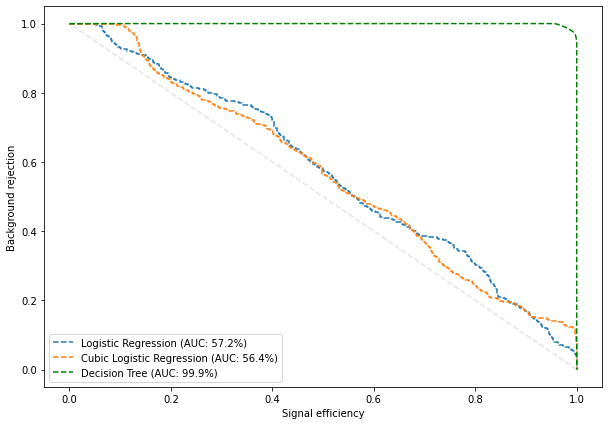

In [8]:
plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, logistic_regression, "Logistic Regression", '--')
plot_roc(X, c, polynomial_logistic, "Cubic Logistic Regression", '--')
plot_roc(X, c, dt, "Decision Tree", 'g--')
plt.legend(loc='lower left')

plt.show()



### *Over-traininig* or *over-fitting* and validation of the model

While building the statistical model, ensuring a good generalization of the model to a dataset statistically equivalent to the one used for training is of crucial importance. At the cost of stating the obvious, we notice that the training sample, by definition, has labels. Achieving perfect splitting of signal and background candidates does not require any algorithm, you can just pick as signal the entries labeled as such. The statistical model is necessary when we wish to apply it to events indepedent of the training sample for which we do not have, and it is too expensive to obtaien, the label. Hence, the *performance* metric that we are ultimately interested in has to be computed on a dataset independent of the training one.

Hence, once the algorithm is trained it is a good idea to validate it, applying a portion of the training, labeld data reserved for validation and never presented to the algorithm in the training procedure. We will then compare the prediction of the algorithm on these data with the label.
If the *performance* is not too different between the two training and the validation dataset, we will conclude that the generalization is good. 
On the other hand, if the *performance* on the validation sample is much worse than on the training data, we may conclude that the model does not generalize well. 
Intuitively, we can imagine the algorithm is learning by heart every single entry of the training dataset being able to perfectly spearate them, without even trying to build a statistical model with rules applicable to equivalent samples.

Let's apply this procedure to our Decision Tre, trained with `max_depth=20` on statistically equivalent dataset comparing the two ROC curves.


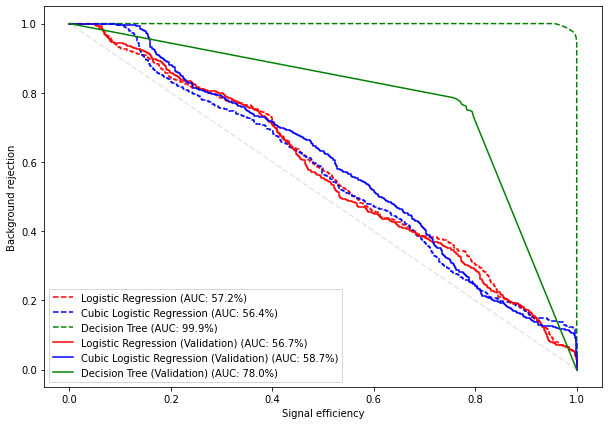

In [9]:
plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, logistic_regression, "Logistic Regression", 'r--')
plot_roc(X, c, polynomial_logistic, "Cubic Logistic Regression", 'b--')
plot_roc(X, c, dt, "Decision Tree", 'g--')

# Validation sample
vx0, vy0, vx1, vy1 = generate_dataset()
vX = np.concatenate((np.c_[vx0,vy0], np.c_[vx1,vy1]))
vc = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

plot_roc(vX, vc, logistic_regression, "Logistic Regression (Validation)", 'r-')
plot_roc(vX, vc, polynomial_logistic, "Cubic Logistic Regression (Validation)", 'b-')
plot_roc(vX, vc, dt, "Decision Tree (Validation)", 'g-')

plt.legend(loc='lower left')
plt.show()

We observe that the *performance* on the validation sample is drastically reduced, with an AUC around 80%.
This effect of limited generalization is named *over-training* or *over-fitting*.

Now, despite the evident effect of *over-training* in the BDT, we would still prefer using it rather than a logistic regression.
Indeed, while it is undenyably true that the BDT is over-trained, its *performance* is still better than the logistic regression that still *generalizes* perfectly.

On the other hand, our BDT may perform better on the validation sample just reducing a little bit the maximal depth, or in general the complexity of the algorithm. In this particular example, we obtain a better AUC on the validation sample using a tree with `max_depth = 15` than `max_depth = 20`.

To summarize, we should never trust the *performance* metric as obtained on the training dataset, though it may be useful to be compared with the *performance* on the *validation* data to assess the generalization properties of the dataset.

### Counteract *over-training*.
In order to improve the ability of the model to generalize to data entries never seen before we can adopt multiple strategies:
 * increase the statistics of the training sample: if possible, increasing the statistics of the training sample enable the training of statistical models closer to the generative distribution of the two datasets, improving the generalization capabilities.
 * reducing the complexity of the model, if it is not possible or too expensive to increase significantly of the training dataset, we can try reducing the complexity of the model. For example, we can reduce the number of input variables, or, in the case of a decision tree, we can reduce the maximal depth, in a wy to make the model less able to memorize fluctuations and therefore less sensitive to differences between the training and the validation datasets.
 * regularize the model: if possible we can add rules to the model to make it more difficult for it to *learn* the fluctuations. This is an explicit way of injecting domain knowledge in the problem. Most of the regularization techniques introduce penalties against too sharp variations of the generative pdf (Lipshitz pdf). IIn Decision Trees, a simple way to achieve this is to forbid to construct leaves with a number of entries too small. In this way we provide the decision tree with the complexitiry needed to descrive complicated datasets in those regions where the statistics is available, while avoiding a single misplaced data entry in a stgatistics-poor region can modify too much the shape of the generative pdf.
 
 In the example below we try to regularize the decision tree, by forbidding leaves with less than 5 data entries.


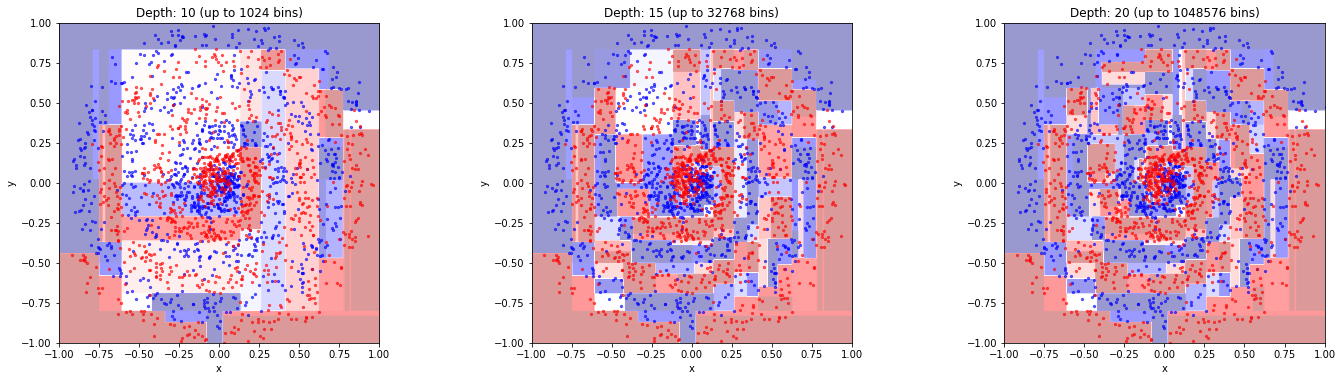

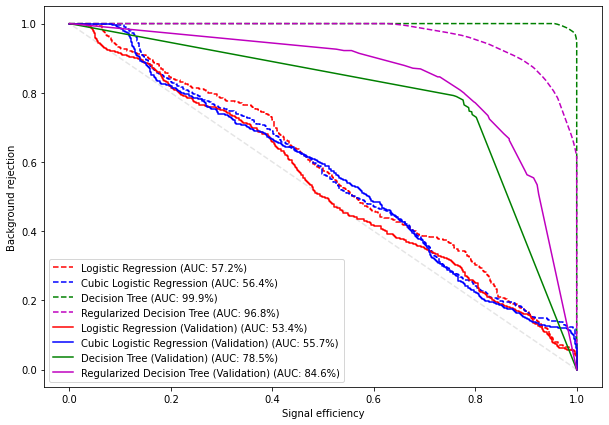

In [10]:
from sklearn.tree import DecisionTreeClassifier as Dt
plt.figure(figsize=(20,10))

for iPlot, depth in enumerate([10, 15, 20], 1):
    plt.subplot(2,3, iPlot)

    ## Instance and configure
    rdt = Dt(max_depth=depth, min_samples_leaf=5)
    X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
    c = np.concatenate((np.zeros(n0), np.ones(n1)))

    ## Train
    rdt.fit(X, c)
    make_plot(rdt, "Decision Tree")
    plt.title(f"Depth: {depth} (up to {2**depth} bins)")
plt.tight_layout()

plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, logistic_regression, "Logistic Regression", 'r--')
plot_roc(X, c, polynomial_logistic, "Cubic Logistic Regression", 'b--')
plot_roc(X, c, dt, "Decision Tree", 'g--')
plot_roc(X, c, rdt, "Regularized Decision Tree", 'm--')

# Validation sample
vx0, vy0, vx1, vy1 = generate_dataset()
vX = np.concatenate((np.c_[vx0,vy0], np.c_[vx1,vy1]))
vc = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

plot_roc(vX, vc, logistic_regression, "Logistic Regression (Validation)", 'r-')
plot_roc(vX, vc, polynomial_logistic, "Cubic Logistic Regression (Validation)", 'b-')
plot_roc(vX, vc, dt, "Decision Tree (Validation)", 'g-')
plot_roc(vX, vc, rdt, "Regularized Decision Tree (Validation)", 'm-')

plt.legend(loc='lower left')
plt.show()

## *Ensemble learning* and *Decision forest*

A widely adopted technique to construct statistical models based on simple algorithms (as for example decision trees) is that of training multiple algorithms that, *a priori*, are equivalent and then combine them into a single classifier, for example averaging their responses or implementing some *voting system* in which the best prediction is the one indicated by the majority of the algoritms in the ensemble.

This technique, name *ensemble learning* or some time *meta learning* is applicable to a variety of algorithms, but it is widely adopted in particular for decision trees. Combining multiple decision trees, grown with a small depth and randomly selecting portions of the training samples, it is possible to obtain predictions generalizing rather well, with algorithms intrisically very simple and easily parallelizable. 

These algorithms are usually referred to as *Random Forest*s and are important in the landscape of machine learning because, while not outstanding in terms of complexity of the trained model, they have very feww *hyper-parameters* and work decently on a wide variety of problems. 
For this reason, *Random Forests* are often the baseline practitioners start with one facing a new classification task, using it term of comparison with more advanced algoritms, seeking for relevant improvements.

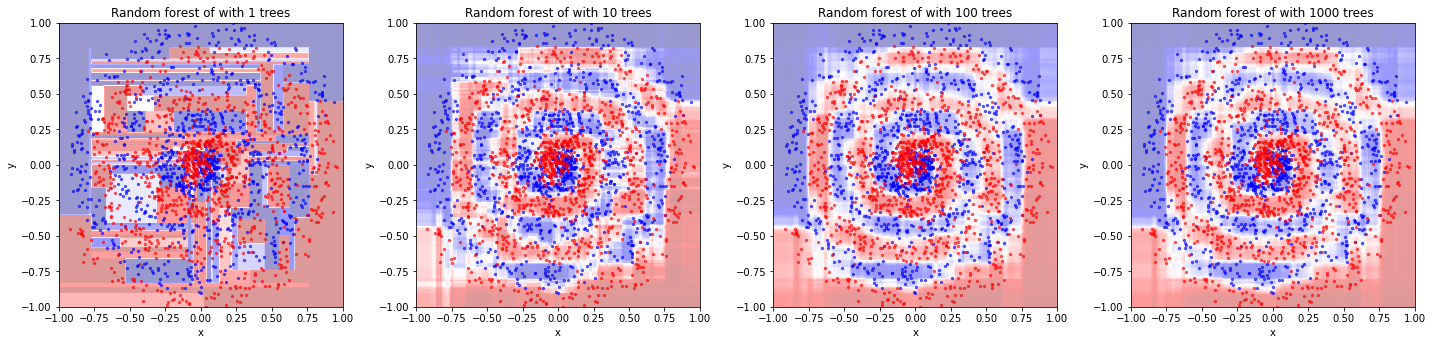

In [11]:
from sklearn.ensemble import RandomForestClassifier as RF
plt.figure(figsize=(20,10))

for iPlot, n_estimators in enumerate([1, 10, 100, 1000], 1):
  rf = RF(n_estimators=n_estimators, max_depth=15, min_samples_leaf=4, max_samples=0.8)
  X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
  c = np.concatenate((np.zeros(n0), np.ones(n1)))
  rf.fit(X, c)
  plt.subplot(1,4,iPlot)
  make_plot(rf, f"Random forest of with {n_estimators} trees")
plt.tight_layout()

### Boosted Decision Trees 
The most important *pro* of *Random Forests* is also the most important *con*: each tree is grown independently of the others. 
This characteristic makes it difficult to correct the training procedure for keeping in higher consideration the rare events, even if they are grouped in a specific region of the parameter space.
For this reason, the ML community developed *Boosted Decision Trees*, algorithms relying on ensembles of *Decision Trees* trained in a sequence, trying for each tree to mitigate the errors introduced in the previous steps.

Among the *boosting* algorithms, two are particularly popular:
 * **AdaBoost** which is based on the idea of weighing events with a larger weight if they were poorly identified up to the previous step;
 * **Gradient Boosing** which is based on the attempt of predicting, for each combination of the parameter space, the contribution to the binary crossentropy up to the previous step, correcting the growth consequently. 

Useful readings can be found in :
 * [The User's Guide of scikit-learn](https://scikit-learn.org/stable/modules/ensemble.html)
 * [A lecture on BDTs I prepared for another school](https://colab.research.google.com/drive/18NHWmORaYDtpQq74mKJwTb97UZ1R2w0w?usp=sharing)

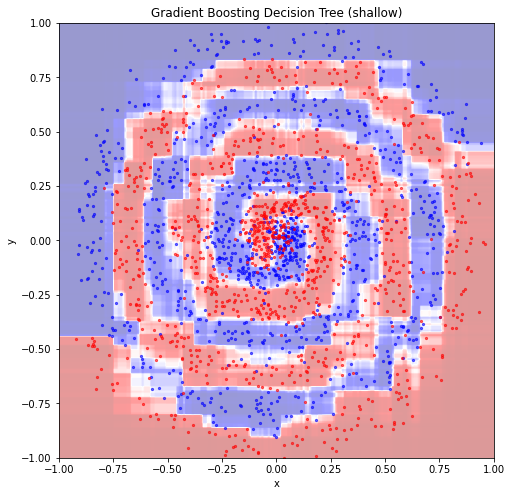

In [12]:
from sklearn.ensemble import GradientBoostingClassifier as Gbdt

bdt = Gbdt(n_estimators=60, max_depth=10, min_samples_leaf=10)
X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(n0), np.ones(n1)))
bdt.fit(X, c)
plt.figure(figsize=(8,8))
make_plot(bdt, "Gradient Boosting Decision Tree (shallow)")

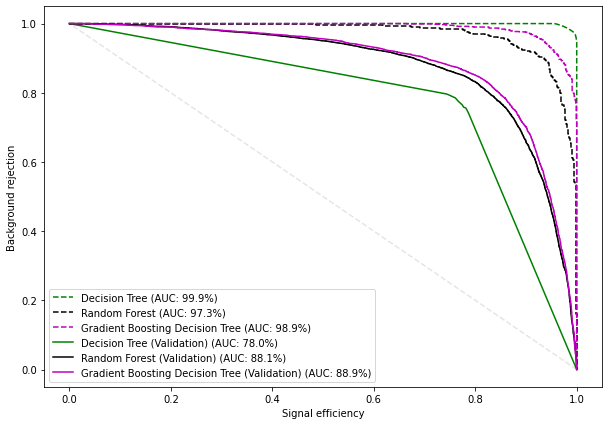

In [13]:
plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, dt, "Decision Tree", 'g--')
plot_roc(X, c, rf, "Random Forest", 'k--')
plot_roc(X, c, bdt, "Gradient Boosting Decision Tree", 'm--')

# Validation sample
vx0, vy0, vx1, vy1 = generate_dataset(n0=10000, n1=10000)
vX = np.concatenate((np.c_[vx0,vy0], np.c_[vx1,vy1]))
vc = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

plot_roc(vX, vc, dt, "Decision Tree (Validation)", 'g-')
plot_roc(vX, vc, rf, "Random Forest (Validation)", 'k-')
plot_roc(vX, vc, bdt, "Gradient Boosting Decision Tree (Validation)", 'm-')


plt.legend(loc='lower left')

plt.show()


From the comparison of the *performance* of Decision Tree, Random Forest and GBDT on this difficult dataset, we observe that the tree of them are overtrained, but the AUC is still in the range 80-90% on the validation sample, which is not that bad! Still, it seems our eye may perform better.

In particular, thinking back to the *No Free Lunch Theorem*, the assumptions on which the construction of the *decision tree* are based are rather different from those that are relevnt to the dataset we are considering.

In particular, in the sample we are studying:
 * the separation between the two categories is not sharp, but (by construction) the joint *pdf*s are superposed
 * the regions associated to the same probability are not parallel to the Cartesian axes, but rather strucutred in a more circular way
 
Can other algorithms fit better to this use case?

## Artificial Neural Networks (ANNs)

The first attempt we discussed to build a statistical model for our rolled dataset was based on the logistic regression, that we have then tried to modify adding variables as obtained with **non linear transformations** of the original features.

Instead of using exponentiation to achieve a sort of polynomial logistic regression, we may try using optimal transformation to solve this particular problem.
To be optimal, it would be useful if it was easy to optimize it for our task numerically, which implies their gradient should be simple to compute.
Let's try to define transformations following these simple rules:
 * transformations are described as the composition of functions: the gradient of the composition of functions is defined by an analytical form (the so called *chain rule*)
 * the elementary trasformations we wish to compose are either:
   * *element-wise transformations*, which act in the same way on each element of the vector taken as *input*, and in this case the gradient is simply the derivative of the function with respect to each element; or
   * *linear*, which imply it can be expressed as a linear application such as $\mathbf{A}\vec x + \vec b$. The Jacobi matrix of this transformation, is simply $A$ 

Such a transform can be written in a generic form as 
$$
\vec h = f(\mathbf A\vec x + \vec b) 
$$
where
 * $\vec h$ is the **representation** that we will pass to the **logistic regression** as an input; 
 * $\vec x$ is the vector of the original features;
 * $\mathbf A$ e $\vec b$ are free parameters to be optimized

We can complete the definition of the classification algorithm, making the regression logistic part explicit, writing:
$$
\hat y = \sigma \Big( w^{\mathrm T} f(\mathbf A\vec x + \vec b) + y_0\Big)
$$
where:
 * $\sigma(\cdot)$ is the sigmoid function
 * $\hat y$ is the probability that a point input features $\vec x$ belongs to the class labelled as $1$
 * $w^\mathrm T$, $\mathbf A$, $\vec b$ e $y_0$ are free parameters to be optimized with gradient descent. 

This expression defines a simple **Artificial Neural Network**, called **Multi-Layer Perceptron** (ML).
We may extend the reasoning applying the MLP to a set of features obtained applying an optimal non-linear transformation.
Each of these transformations will be named *layer* and adding *layers* to the *neural network* it becomes *deeper*, becoming a **Deep Neural Network**.

The most performant Neural Networks are obtained with dedicated libraries such as *keras*, *tensorflow* or *pytorch*. 
These libraries are different from scikit-learn because they are based on re-implementation of all the algeabric and analytical operations of numpy to ease the compuation of derivatives and gradients in a quasi-analytical way, making it dramatically faster to reach the minimum in the optimization phase.

*scikit-learn* offers its own implementation of an MLP which is perfect for simple problems with up to a few thousands of free paramenters.

Let's see it in action, with a single layer between the input and the representation (and therefore called sometime a shallow neural network)

/Users/lucio/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


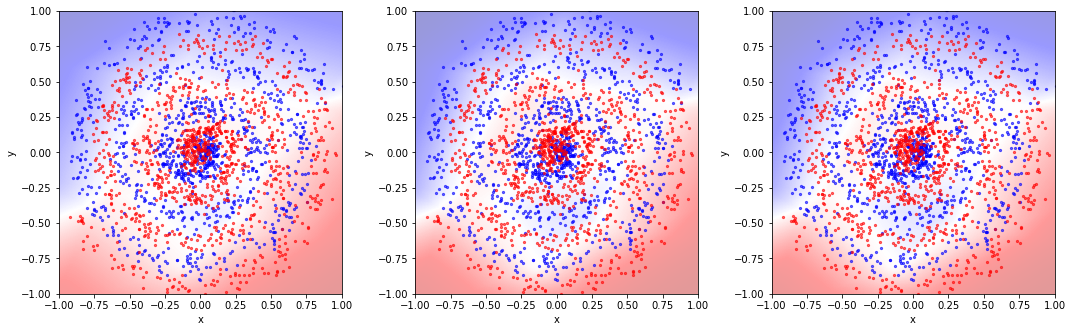

In [14]:
from sklearn.neural_network import MLPClassifier as Ann

ann = Ann(activation='relu', hidden_layer_sizes=(128), warm_start=True)
X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(n0), np.ones(n1)))
plt.figure(figsize=(15,5))
for i in range(3):
  plt.subplot(1,3,i+1)
  ann.fit(X, c)
  make_plot(ann)

plt.tight_layout()

The difference with the result obtained using Decision Trees is evident and reminds vaguely the result obtained with polynomial regression, which is indeed a conceptually similar algorithm.

From the point of view of the *performance*, however, the result is rather scarce if compared with *Boosted Decision Trees*.

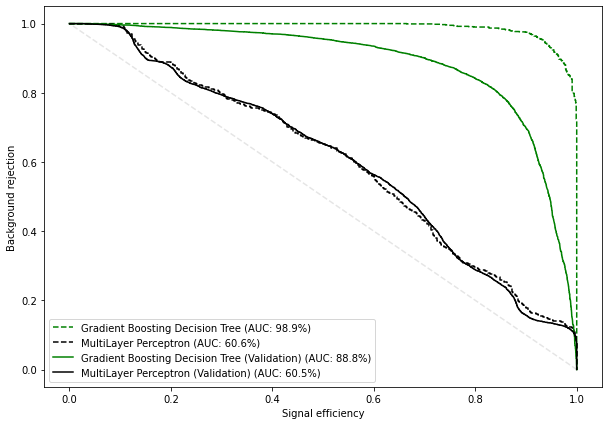

In [15]:
plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, bdt, "Gradient Boosting Decision Tree", 'g--')
plot_roc(X, c, ann, "MultiLayer Perceptron", 'k--')

# Validation sample
vx0, vy0, vx1, vy1 = generate_dataset(n0=10000, n1=10000)
vX = np.concatenate((np.c_[vx0,vy0], np.c_[vx1,vy1]))
vc = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

plot_roc(vX, vc, bdt, "Gradient Boosting Decision Tree (Validation)", 'g-')
plot_roc(vX, vc, ann, "MultiLayer Perceptron (Validation)", 'k-')

plt.legend(loc='lower left')

plt.show()

Let's try preprocessing the variables with a polynomial trasformation as we did for the logistic regression, to see things improving significantly.

/Users/lucio/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


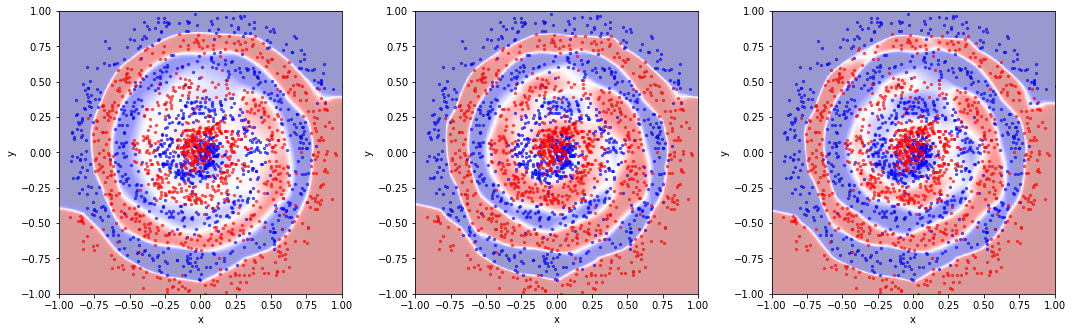

In [16]:
poly = PolynomialFeatures(3)
method = Ann(activation='relu', hidden_layer_sizes=(128, 128), warm_start=True)
polyann = Pipeline([('poly', poly), ('method', method)])

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(n0), np.ones(n1)))
plt.figure(figsize=(15,5))
for i in range(3):
  plt.subplot(1,3,i+1)
  polyann.fit(X, c)
  make_plot(polyann)

plt.tight_layout()

Still, in the middle of the image, around the point (0, 0), the network has hard times disentagling the two categories (signal and background).
This is a numerical problem, the order of magnitude of the powers of the input features varies too much and the optimization is therefore difficult.
We can help the convergence of the optimization algorithm by preprocessing the inputs and making them all of the same order of magnitude.
In scikit-learn, this can be achieved for example with the `StandardScaler` class.

/Users/lucio/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


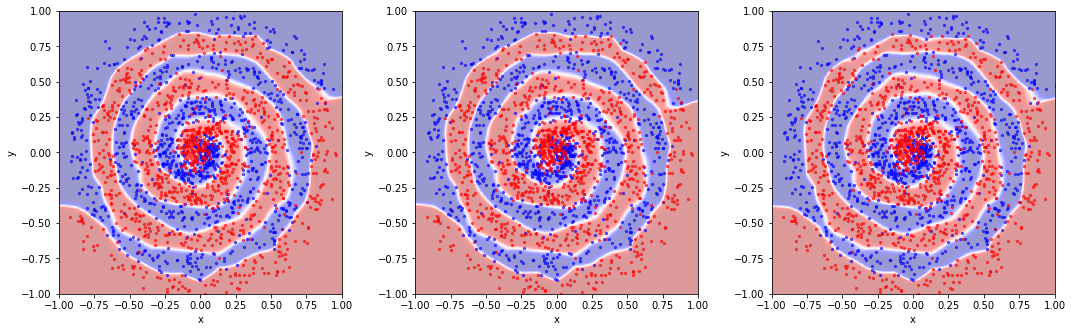

In [17]:
from sklearn.preprocessing import StandardScaler

poly = PolynomialFeatures(3)
method = Ann(activation='relu', hidden_layer_sizes=(128, 128), warm_start=True)
scaled_polyann = Pipeline([('poly', poly), ('scaler', StandardScaler()), ('method', method)])

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(n0), np.ones(n1)))
plt.figure(figsize=(15,5))
for i in range(3):
  plt.subplot(1,3,i+1)
  scaled_polyann.fit(X, c)
  make_plot(scaled_polyann)

plt.tight_layout()

From the comparison of the various algorithms, we observe that we managed to push the network to a *performance* which is superior to that of the *BDT*, with a level of *over-training* which is more limited and all in all acceptable.


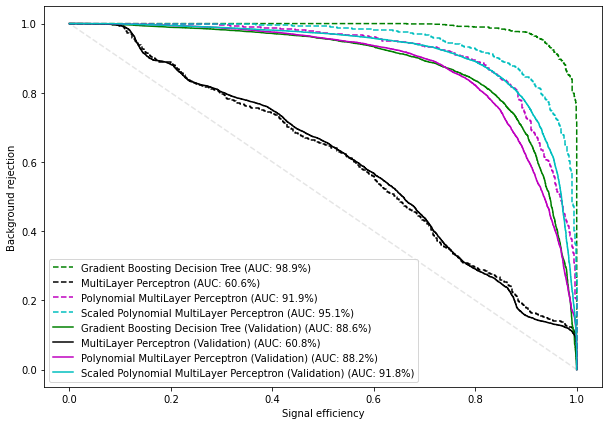

In [18]:
plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, bdt, "Gradient Boosting Decision Tree", 'g--')
plot_roc(X, c, ann, "MultiLayer Perceptron", 'k--')
plot_roc(X, c, polyann, "Polynomial MultiLayer Perceptron", 'm--')
plot_roc(X, c, scaled_polyann, "Scaled Polynomial MultiLayer Perceptron", 'c--')



# Validation sample
vx0, vy0, vx1, vy1 = generate_dataset(n0=10000, n1=10000)
vX = np.concatenate((np.c_[vx0,vy0], np.c_[vx1,vy1]))
vc = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

plot_roc(vX, vc, bdt, "Gradient Boosting Decision Tree (Validation)", 'g-')
plot_roc(vX, vc, ann, "MultiLayer Perceptron (Validation)", 'k-')
plot_roc(vX, vc, polyann, "Polynomial MultiLayer Perceptron (Validation)", 'm-')
plot_roc(vX, vc, scaled_polyann, "Scaled Polynomial MultiLayer Perceptron (Validation)", 'c-')

plt.legend(loc='lower left')

plt.show()

## Understanding the problem is often better than trial and error

BDTs and Neural Networs are powerful algorithms that enable decent results with extremely limited effort and in conditions in which making assumptions on the dataset is objectively difficult. 
However, we can "help" these algorithms keeping in mind which assumptions we can inject in the solution of the problem according to our experinece and human creativity.

For example, in the specific case of this dataset, our human eye and our experience after some physics lectures suggests that if we had to solve this problem analytically, we would probably trasnform it in polar coordinate as a first step.

Even if here we are not doing things analytically, the fact that the describing the problem with polar coordinate is easier remains true, and simpler model can achieve better tasks.

Clearly, a sufficiently deep neural network would still be able to learn that such a polar representation is the one that better describe the problem, but it will need a large statistics to convince itself to chose that representation rather than one wrapping all the entries at the boundary with ad-hoc boundaries.
The point is that for a neural network the formula $(x^2 + y^2)^{\frac{1}{2}}$ has nothing special. All the $2$\`s appearing in the formula must be learned independently and described in a quasi-polynomial approximation obtained combining matrix operations and element wise operations. 

For this reason, wherever it is possible, we should help the algorithm to identify the optimal representation to our problem, which implies that we are injecting assumptions on the nature of the dataset.

Look at this problem in polar coordinates:

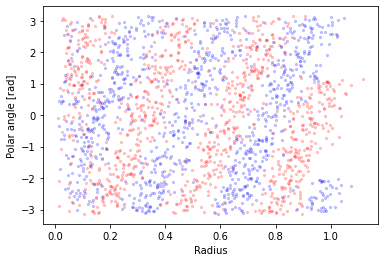

In [19]:
from sklearn.preprocessing import FunctionTransformer
X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))

prep = FunctionTransformer(lambda x: np.c_[(x[:,0]**2 + x[:,1]**2)**0.5, np.arctan2(x[:,0], x[:,1])])

pX = prep.transform(X)
plt.scatter(pX[c==0,0], pX[c==0,1], color='red', s=5, alpha=0.2)
plt.scatter(pX[c==1,0], pX[c==1,1], color='blue', s=5, alpha=0.2)
plt.xlabel("Radius")
plt.ylabel("Polar angle [rad]")
plt.show()

Still, it's not ideal for a BDT, but for a Neural Network it is almost a trivial task!
With a single, small, layer we get better performance than the best BDT we managed to train!

/Users/lucio/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


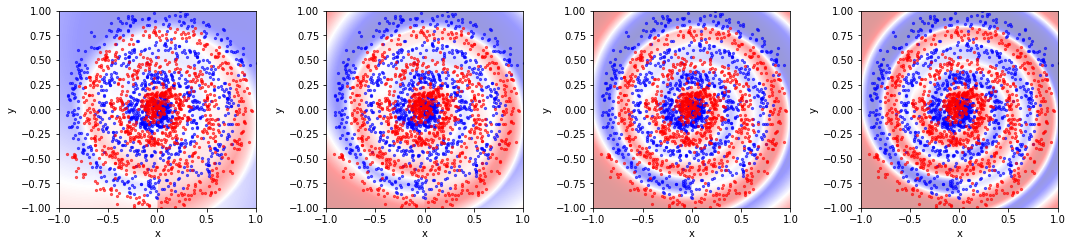

In [20]:
from sklearn.preprocessing import StandardScaler
prep = FunctionTransformer(lambda x: np.c_[(x[:,0]**2 + x[:,1]**2)**0.5, np.arctan2(x[:,0], x[:,1])])
method = Ann(activation='relu', hidden_layer_sizes=(128), warm_start=True)
scaler = StandardScaler()
preprocessed_ann = Pipeline([('prep', prep), ('scaler', scaler), ('method', method)])

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
y = np.concatenate((np.zeros(n0), np.ones(n1)))
plt.figure(figsize=(15,5))

for i in range(4):
  plt.subplot(1,4,i+1)
  preprocessed_ann.fit(X, c)
  make_plot(preprocessed_ann)

plt.tight_layout()

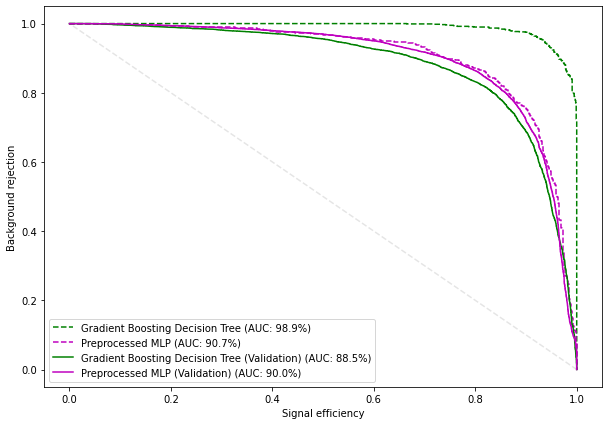

In [21]:
plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, bdt, "Gradient Boosting Decision Tree", 'g--')
plot_roc(X, c, preprocessed_ann, "Preprocessed MLP", 'm--')


X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

# Validation sample
vx0, vy0, vx1, vy1 = generate_dataset(n0=10000, n1=10000)
vX = np.concatenate((np.c_[vx0,vy0], np.c_[vx1,vy1]))
vc = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

plot_roc(vX, vc, bdt, "Gradient Boosting Decision Tree (Validation)", 'g-')
plot_roc(vX, vc, preprocessed_ann, "Preprocessed MLP (Validation)", 'm-')


plt.legend(loc='lower left')

plt.show()

As per comparison, this is what happens when training the BDT on polar coordinates.

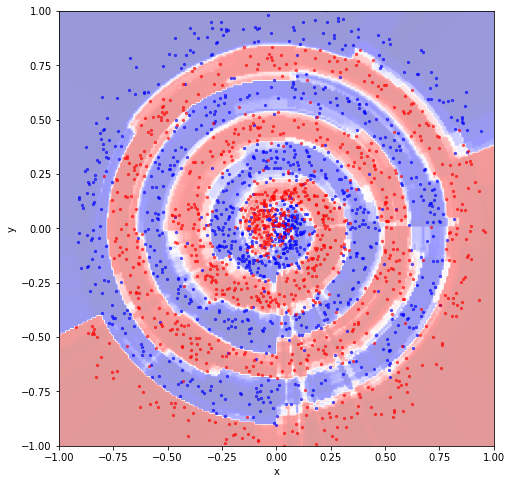

In [22]:
from sklearn.preprocessing import StandardScaler
prep = FunctionTransformer(lambda x: np.c_[(x[:,0]**2 + x[:,1]**2)**0.5, np.arctan2(x[:,0], x[:,1])])
method = Gbdt(n_estimators=60, max_depth=10, min_samples_leaf=10)
scaler = StandardScaler()
preprocessed_bdt = Pipeline([('prep', prep), ('scaler', scaler), ('method', method)])

X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
y = np.concatenate((np.zeros(n0), np.ones(n1)))
preprocessed_bdt.fit(X, y)

plt.figure(figsize=(8,8))
make_plot(preprocessed_bdt)
plt.show()

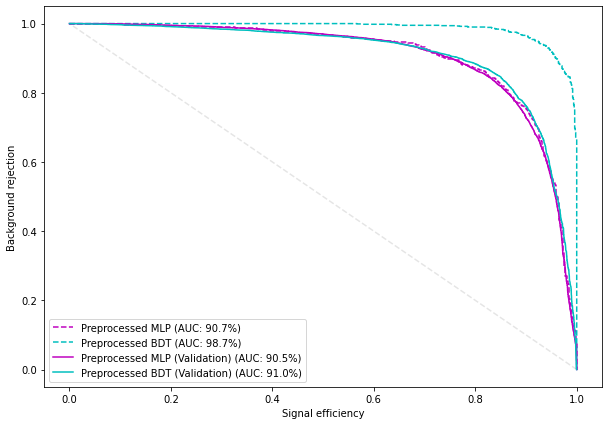

In [23]:
plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, preprocessed_ann, "Preprocessed MLP", 'm--')
plot_roc(X, c, preprocessed_bdt, "Preprocessed BDT", 'c--')


X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

# Validation sample
vx0, vy0, vx1, vy1 = generate_dataset(n0=10000, n1=10000)
vX = np.concatenate((np.c_[vx0,vy0], np.c_[vx1,vy1]))
vc = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

plot_roc(vX, vc, preprocessed_ann, "Preprocessed MLP (Validation)", 'm-')
plot_roc(vX, vc, preprocessed_bdt, "Preprocessed BDT (Validation)", 'c-')


plt.legend(loc='lower left')

plt.show()

## The classification task with Minuit
To conclude the discussion on the classification models, we consider the extreme case in which we known the parametric shape of the generative distributions of the data we are trying to classify and we build an analytic classifier optimized for example with Minuit.

In this case we are not simply modifying the representation of the data in a way that the separation can be leart as a linear relation, we are building a statistical model completely specialized to our task.

From the point of view of the No Free Lunch Theorem, we are injecting in the algorithm the maximum degree of available knowledge of the dataset we are trying to classify, and therefore we expect outstanding performance both in terms of discriminating power and in terms of generalization capabilities.

To build our model we will start from the [Neyman-Pearson lemma](https://en.wikipedia.org/wiki/Neyman%E2%80%93Pearson_lemma) stating that in the hypothesis testing problems between two different alternatives $H_0$ and $H_1$, the most powerful test statistics is provided by the likelihood ratio
$$
T = \frac{\mathcal L(H_0 | \vec x)}{\mathcal L(H_0 | \vec x)}
$$

We often prefer the logarithmic version of this formula
$$
\log T = \log \frac{\mathcal L(H_0 | \vec x)}{\mathcal L(H_0 | \vec x)}
$$

If you now remember that the this has to be mapped to the interval [0, 1], we could build our classifier composing this classifier with a sigmoid:
$$
\mathrm p(\vec x|\vec \theta) = f(\vec x | \vec \theta) = \sigma\left(\log\left(\frac{\mathrm{pdf}(True|\vec x, \hat \theta)}{\mathrm{pdf}(False|\vec x, \hat \theta)}\right)\right)
$$

Now, writing the *pdf*s for this problem is not trivial.
A possible approach is inverting the transfrom problem that we used to build the dataset randomly. If we apply the inverse of the transformation to the points of our datasets we will get a Gaussian distributed dataset by construction.

The "formula" we used to build our dataset is
$$
\left\{
  \begin{array}{l}
    x = t \sin(ft + \varphi)\\
    y = t \cos(ft + \varphi)\\
  \end{array}
\right.
$$
to which a Gaussian noise with standard deviation $\sigma$ is superposed.

The free parameters in our fit will be $f$, $t$ and $\phi$, but we only expect the latter to differ for the blue and red datasets

Then we can try to write that given the arbitary pair $(x, y)$,
$$
\theta = \arctan\left(\frac{y}{x}\right) \qquad t = \sqrt{x^2 + y^2}
$$
and
$$
\hat \varphi = \theta - ft
$$
We can then assume a *pdf* with the shape
$$
\mathrm {pdf}(\theta, t|f, \phi, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(\varphi - \theta + ft)^2}{2\sigma^2} \right)
$$

The test statistics will look like
$$
\log T = \log \left(\frac{\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(\varphi_1 - \theta + ft)^2}{2\sigma^2} \right)}{\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(\varphi_2 - \theta + ft)^2}{2\sigma^2} \right)}\right)
$$

We wil need then to map $\log T$ to the interval [0, 1), by using the sigmoid function.
$$
p(x,y|f,\sigma,\varphi_1,\varphi_2) = \frac{1}{1 + \exp(-\log T)}
$$





┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 722.3                      │              Nfcn = 259              │
│ EDM = 5.86e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ f     │   19.85   │   0.09    │            │            │         │         │       │
│ 1 │ sigma │   1.124   │   0.023   │            │            │         │         │       │
│ 2 │ phi0  │   0.18    │   0.09    │            │            │         │         │       │
│ 3 │ phi1  │   2.90    │   0.07    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │         f     sigma      phi0      phi1 │
├───────┼─────────────────────────────────────────┤
│     f │   0.00843  8.21e-05  -0.00481  -0.00361 │
│ sigma │  8.21e-05  0.000535  -0.00039  0.000311 │
│  phi0 │  -0.00481  -0.00039   0.00725 -0.000695 │
│  phi1 │  -0.00361  0.000311 -0.000695   0.00549 │
└───────┴─────────────────────────────────────────┘

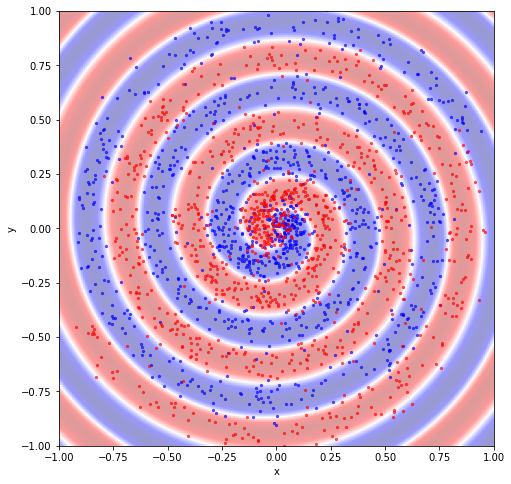

In [24]:
!pip install -q iminuit 
from iminuit import Minuit

class CustomModel:
    """Classifier based on explicit modelling of the pdfs"""
  
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.minuit = Minuit(self.loss, f=20, sigma=1, phi0=0, phi1=1)
        self.minuit.errordef = 0.5
        self.minuit.simplex().migrad()

        del self.X
        del self.y

        return self

    def custom_pdf (self, xy, f=20, phi=0, sigma=0.4):
        theta = np.arctan2(xy[:,0], xy[:,1])
        t = np.linalg.norm(xy, axis=1)

        phi_hat = theta - f * t
        return np.exp(-((phi_hat - phi + np.pi)%(2*np.pi) - np.pi)**2/(2*sigma**2))/(np.sqrt(2*np.pi*sigma**2))

    def predict_proba (self, X):
        return self.decision_function(X, *self.minuit.values)

    def decision_function (self, X, f=20, sigma=0.5, phi0=0, phi1=np.pi):
        pdf0 = self.custom_pdf(X, f=f, phi=phi0, sigma=sigma)
        pdf1 = self.custom_pdf(X, f=f, phi=phi1, sigma=sigma)
        p0 = 1/(1+np.exp(-np.log(pdf0/pdf1)))
        return np.c_[p0, 1-p0]

    def loss (self, f=20, sigma=0.5, phi0=0, phi1=10):
        p0, p1 = self.decision_function(self.X, f, sigma, phi0, phi1).T
        return -( np.sum(np.log(p0[self.y==0])) + np.sum(np.log(p1[self.y==1])) )

my_model = CustomModel()
X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
my_model.fit(X, y)

plt.figure(figsize=(8,8))
make_plot(my_model)
my_model.minuit

Let's conclude by comparing the performance of this algorithm with what we got from the other `scikit-learn` methods.

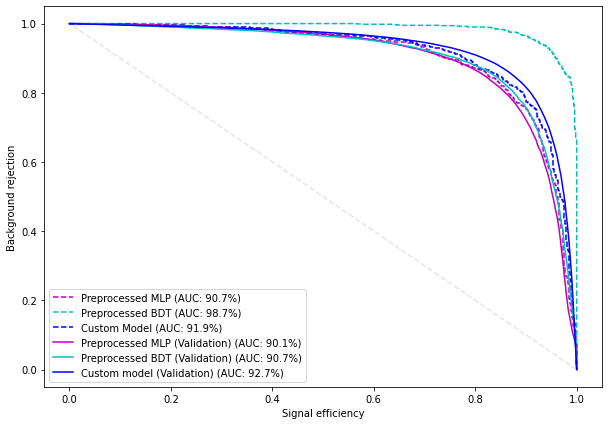

In [25]:
plt.figure(figsize=(10,7))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(x0)), np.ones(len(x1))))
plt.plot([1,0],[0,1], 'k--', alpha=0.1)
plot_roc(X, c, preprocessed_ann, "Preprocessed MLP", 'm--')
plot_roc(X, c, preprocessed_bdt, "Preprocessed BDT", 'c--')
plot_roc(X, c, my_model, "Custom Model", 'b--')


X = np.concatenate((np.c_[x0,y0], np.c_[x1,y1]))
c = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

# Validation sample
vx0, vy0, vx1, vy1 = generate_dataset(n0=100000, n1=100000)
vX = np.concatenate((np.c_[vx0,vy0], np.c_[vx1,vy1]))
vc = np.concatenate((np.zeros(len(vx0)), np.ones(len(vx1))))

plot_roc(vX, vc, preprocessed_ann, "Preprocessed MLP (Validation)", 'm-')
plot_roc(vX, vc, preprocessed_bdt, "Preprocessed BDT (Validation)", 'c-')
plot_roc(vX, vc, my_model, "Custom model (Validation)", 'b-')

plt.legend(loc='lower left')

plt.show()

We observe a slight, but significant improvement of the performance evaluated on the validation sample. 
Besides, the performance obtained on the training sample is extremely close to that obtained for the validation dataset.
Showing that the algorithm generalizes very well to new data entries.


# Conclusioni

In this *notebook* we discussed an important problem in Machine Learning concerning model building, taking as an example the classification task and trying to highlight the implication of injecting hypothesis in the solution of the optimization task. 
We discussed how the ability of a classifier to correctly identifying data entries as belonging to the right category substantially depends on the assumptions on the dataset it is able to leverage.

Advanced algorithms as Boosted Decision Trees and Arficial Neural Networks can modify the represenation of the data in order to learn autonomously the e best transformation to apply. Unfortunately, if not assumptions on the dataset are made, the only criterion an algorithm can use to achieve optimal performance is of statistical nature. But this implies very large datasets are needed.
To study small datasets, we need inject information in the optimization problem, or, in other words, we need to leverage assumptions based on experience and domain knowledge.

In any case, once the algorithm is trained it is always of crucial importance to validate its performance on dataset never seen by the algorithm in the training phase, but statistically equivalent. If the performance of the sample used in validation is too small compared to the training sample, it is likely our algorithm is learning statistical fluctuation in the training sample using those to split the two categories, loosing the ability of generalizing well to other datasets.
This behaviour of optimization algorithms is named *over-training* and we try to reduce it as possible.

In order to avoid over-training we can add information or hypotheses to the optimization procedure. 
This can be achieved in three ways:
 * increasing the statistics of the training dataset;
 * simplifying the model
 * regularizing the model
 
Regularization techniques depend on the chosen algorithm and in general are designed to limit the sensitivity of the algorithm to structures of few entries.

We concluded the dataset reminding that, interpreting loosely the Neyman-Pearon lemma, the most powerful classifier is obtained mapping the likelihood ratio to the two classes and interpreting it as the probability of belonging to the class appearing at the numerator. 
When possible, this is often the most convenient classifier because the importance of the assumptions injected in the mathematical description of the generative pdf is huge.
In reality, however, it is very rare to have a good mathematical description of the generative pdf, especially when the variables are many.

Still, even if we don't have an explicit formula for the *pdf* we can preprocess the data to make it easier for the network to identify the structures that we expect are the most significant. We have seen as an example how the performance of basic algorithms improve drastically simply by passing to polar coordinates.